<a href="https://colab.research.google.com/github/jake-herman/ML4E_project/blob/main/ML4E_FinalProject_basicRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using RNN's to predict physical models

The data is stored as an $(n,d)$ matrix where each of the $n$ rows is a vector of data points of length $d$ containing the height of the ball at each timestep. 

Initial test with various starting points ranging from 1 to 50 meters in height (thus, $n = 50$), each simulation using

*   t_step = 0.01 seconds
*   t_stop = 20 seconds
    * Thus, $d = 2001$
*   coefficient of restitution (COR) = 0.8

In [1]:
import scipy.io
import numpy as np
matlab_data = scipy.io.loadmat('bouncyball_data')
  # saves .mat file as dictionary
data = np.array(matlab_data['data']).T
  # saves data from file as np array
print(data)
print("\nShape =", data.shape)
n = data.shape[0]
d = data.shape[1]

[[ 1.          0.9995095   0.998038   ...  0.          0.
   0.        ]
 [ 2.          1.9995095   1.998038   ...  0.          0.
   0.        ]
 [ 3.          2.9995095   2.998038   ...  0.          0.
   0.        ]
 ...
 [48.         47.9995095  47.998038   ...  0.38416447  0.45805436
   0.53096325]
 [49.         48.9995095  48.998038   ...  1.20448844  1.11609532
   1.02672119]
 [50.         49.9995095  49.998038   ...  2.83724836  2.76830164
   2.69837392]]

Shape = (50, 2001)


To visualize a the data at various time series:

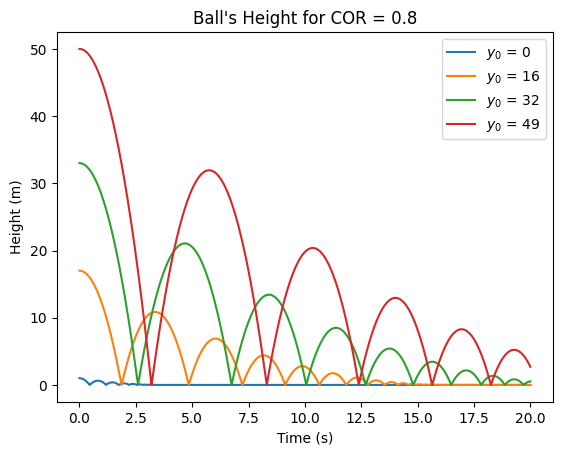

In [2]:
import matplotlib.pyplot as plt
samples = np.linspace(0,n-1,4,dtype=int)
times = np.linspace(0,(d-1)*.01,d)
for i in samples:
    plt.plot(times,data[i,:])
plt.xlabel('Time (s)')
plt.ylabel("Height (m)")
plt.title("Ball's Height for COR = 0.8")
plt.legend(["$y_0$ = {}".format(j) for j in samples])
plt.show()

Processing the data to split it into training, validation, and testing

In [3]:
np.random.shuffle(data)
  # shuffle data vectors
X_train,  y_train  = data[:35, :d-1] , data[:35,-1]
  # X_train - first 35 rows with all but last data point
  # y_train - last data point for each respective row
X_val,    y_val    = data[35:45, :d-1] , data[35:45,-1]
  # X_val - next 10 rows with all but last data point
  # y_val - last data point for each respective row
X_test,   y_test   = data[45:, :d-1]  , data[45:,-1] 
  # X_test - final 5 rows with all but last data point
  # y_test - last data point for each respective row

In [4]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential([
        keras.layers.GRU(20, activation = "relu", return_sequences=True, input_shape=[None, 1]),
        keras.layers.GRU(20, activation = "relu", return_sequences=False), 
        keras.layers.Dense(1) # dense layer
])
model.summary()

model.compile(loss="mse", optimizer="adam")

history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_val, y_val))

mse_test = model.evaluate(X_test, y_test)

print(f"MSE on test set: {mse_test:.3f}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 20)          1380      
                                                                 
 gru_1 (GRU)                 (None, 20)                2520      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 3,921
Trainable params: 3,921
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2/2 [==============================] - 13s 3s/step - loss: 1.3590 - val_loss: 1.0966
Epoch 2/20
2/2 [==============================] - 3s 2s/step - loss: 1.3028 - val_loss: 1.0489
Epoch 3/20
2/2 [==============================] - 4s 2s/step - loss: 1.2522 - val_loss: 1.0033
Epoch 4/20
2/2 [================

Now that the model is trained, we can use it to predict the future of a much longer data set

In [5]:
matlab_data = scipy.io.loadmat('predict_2001')
  # saves .mat file as dictionary
X_new = np.array(matlab_data['testdata']).T/10

X = X_new[:,:-10]
for step_ahead in range(10):
        y_pred_one = model.predict(X[:, step_ahead:])
        X = np.concatenate([X, y_pred_one], axis=1)
Y_pred = X[:, n:]
print(Y_pred)

1/1 [==============================] - 0s 166ms/step
[[9.877375   9.87242095 9.8673688  ... 0.13395411 0.1193268  0.10887161]]


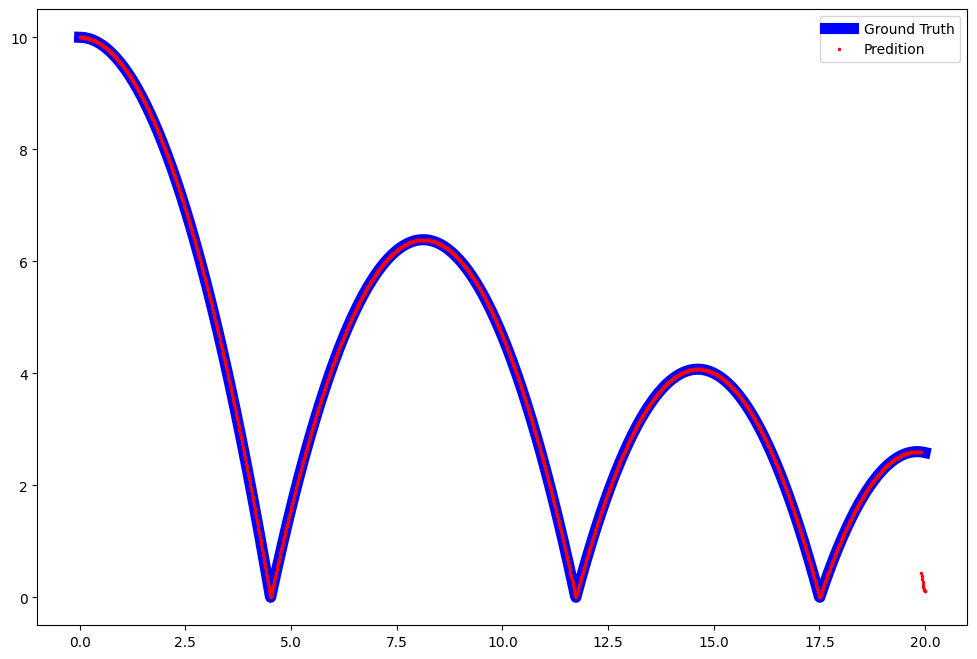

In [6]:
times = np.linspace(0,20,2001)
  # analyzing the final 100 data points
plt.figure(figsize = (12,8))
plt.plot(times,X_new[0],'b',lw=8)
plt.plot(times,X[0],'r.',ms=3)
plt.legend(["Ground Truth", "Predition"])